# Analysis of Simulation Data
In this notebook, I want to see how many of the simulated cliques are predicted by the GCN algorithm.

In [51]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
#import seaborn

%matplotlib inline

### basic definitions

In [52]:
def read_implant_positions(file):
    with open(file, 'r') as f:
        subnetworks = []
        disease_genes = []
        for subnet in f.readlines():
            if subnet.startswith('#'):
                continue
            vals = [int(i.strip()) for i in subnet.strip().split(':')[1].strip().split('\t')]
            subnetworks.append(vals)
            disease_genes.append(vals[0])
    return pd.DataFrame(subnetworks), disease_genes

def get_top_n_both(scores, disease_genes, n):
    return scores.head(n)[scores.head(n).index.isin(disease_genes)]

def get_recovered_nodes(scores, subnets):
    idx = []
    for score in scores.index:
        if subnets[subnets.isin([int(score)]).any(axis=1)].shape[0] > 0:
            idx.append(score)
    return scores.loc[idx]

In [53]:
pagerank_scores = pd.DataFrame.from_csv('../data/simulation/pagerank_scores_sim.txt', sep='\t')
subnets, disease_genes = read_implant_positions('../data/simulation/implant_positions.txt')

In [54]:
pagerank_scores[pagerank_scores.index.isin(subnets)]

,Gene_Name,Rank,NetRank_Score
Gene_ID,,,
0.0,0.0,681,0.000528
1.0,1.0,853,0.000502
2.0,2.0,932,0.000490
3.0,3.0,946,0.000487
4.0,4.0,985,0.000479


In [125]:
recovered_disease_genes = get_top_n_both(pagerank_scores, disease_genes, 300)
recovered_disease_genes

,Gene_Name,Rank,NetRank_Score
Gene_ID,,,
525.0,525.0,5,0.009391
924.0,924.0,9,0.006083
641.0,641.0,10,0.005996
879.0,879.0,86,0.001710
286.0,286.0,118,0.001427
149.0,149.0,124,0.001402
701.0,701.0,135,0.001356
723.0,723.0,160,0.001266
744.0,744.0,174,0.001183


In [126]:
print ("Recovered {} disease genes within first 300 Ranks".format(recovered_disease_genes.shape[0]))

Recovered 18 disease genes within first 300 Ranks


In [56]:
pr_scores_subnets = get_recovered_nodes(pagerank_scores, subnets)
n = 300
recovered_pr = pr_scores_subnets[pr_scores_subnets.Rank <= n]
print ("Recovered {} implanted nodes within the first {} Ranks".format(recovered_pr.shape[0], n))

Recovered 54 implanted nodes within the first 300 Ranks


# GCN

In [129]:
model_dir = '../data/GCN/training/2018_03_29_11_46_50/'
gcn_pred = pd.DataFrame.from_csv(model_dir + 'predictions.tsv', sep='\t')
gcn_pred.shape

(1053, 2)

In [130]:
scores_diseasegenes_gcn = gcn_pred[gcn_pred.index.isin(disease_genes)]
recovered_diseasegenes_gcn = scores_diseasegenes_gcn[scores_diseasegenes_gcn.Prob_pos > 0.5]
no_dg_gcn = recovered_diseasegenes_gcn.shape[0]
no_pos_pred = gcn_pred[gcn_pred.Prob_pos > 0.5].shape[0]
print ("Recovered {} disease genes with {} positive predictions".format(no_dg_gcn, no_pos_pred))

Recovered 33 disease genes with 211 positive predictions


In [131]:
gcn_idx = []
for score in gcn_pred.index:
    if subnets[subnets.isin([int(score)]).any(axis=1)].shape[0] > 0:
        gcn_idx.append(score)

In [132]:
gcn_pred_for_subnets = gcn_pred.loc[gcn_idx]
gcn_pred_for_subnets.shape

(190, 2)

In [133]:
(gcn_pred.loc[gcn_idx].Prob_pos > .5).shape

(190,)

In [134]:
recovered_gcn = gcn_pred_for_subnets[gcn_pred_for_subnets.Prob_pos > .5]

In [135]:
recovered_gcn.shape, gcn_pred[gcn_pred.Prob_pos > 0.5].shape

((154, 2), (211, 2))

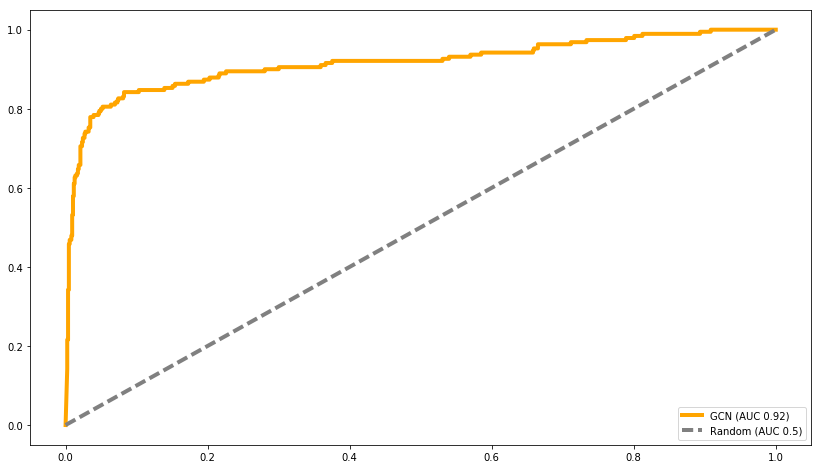

In [139]:
subnet_entries = subnets.values.flatten()
y_true = gcn_pred.index.isin(subnet_entries)
y_score = gcn_pred.Prob_pos
tpr, fpr, _ = roc_curve(y_score=y_score, y_true=y_true)
auc = roc_auc_score(y_score=y_score, y_true=y_true)
fig = plt.figure(figsize=(14, 8))
plt.plot(tpr, fpr, lw=4, color='orange', label='GCN (AUC {0:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], color='gray', lw=4, linestyle='--', label='Random (AUC 0.5)')
plt.legend(loc='lower right')
fig.savefig(model_dir + 'roc_curve_cliquemems_allnodes.png', dpi=300)

0.18043684710351376 190 863


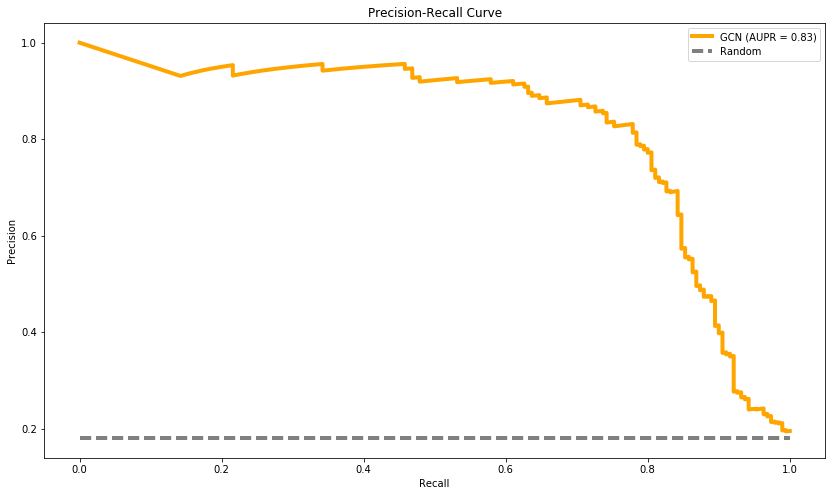

In [138]:

aupr = average_precision_score(y_true, y_score)
pr, rec, thr = precision_recall_curve(y_true, y_score)

fig = plt.figure(figsize=(14, 8))
plt.plot(rec, pr, lw=4, color='orange', label='GCN (AUPR = {0:.2f})'.format(aupr))
random_y = y_true.sum() / (y_true.sum() + y_true.shape[0] - y_true.sum())
print (random_y, y_true.sum(), y_true.shape[0]-y_true.sum())
plt.plot([0, 1], [random_y, random_y], color='gray', lw=4, linestyle='--', label='Random')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
fig.savefig(os.path.join(model_dir, 'prec_recall_cliquemems_allnodes.png'))



In [104]:
from sklearn.metrics import precision_score, recall_score
THRESHOLD = .994
pr_s = precision_score(y_true=y_true, y_pred=y_score >= THRESHOLD)
rec_s = recall_score(y_true=y_true, y_pred=y_score >= THRESHOLD)
print ("[Threshold: {}] Precision: {}\tRecall: {}".format(THRESHOLD, pr_s, rec_s))

[Threshold: 0.994] Precision: 0.9243697478991597	Recall: 0.5789473684210527


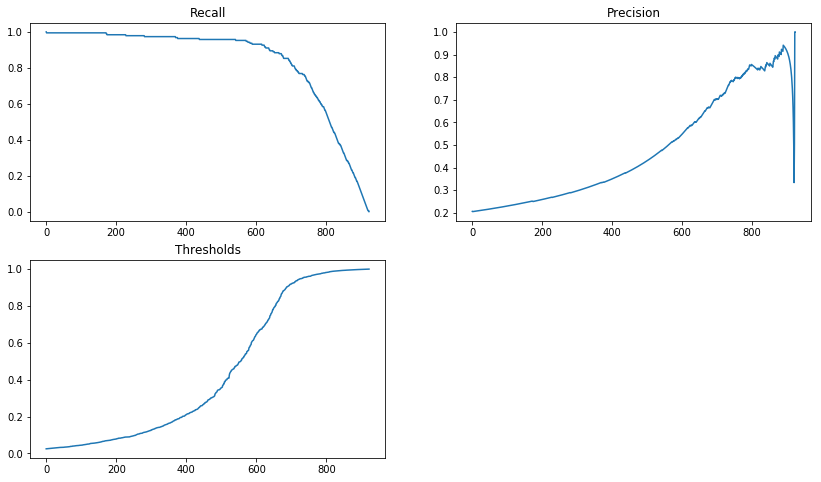

In [80]:
fig = plt.figure(figsize=(14, 8))
plt.subplot(2, 2, 1)
plt.plot(rec)
plt.title('Recall')
plt.subplot(2, 2, 2)
plt.plot(pr)
plt.title('Precision')
plt.subplot(2, 2, 3)
plt.plot(thr)
plt.title('Thresholds')

In [39]:
thr

array([0.01597387, 0.01605777, 0.01612183, 0.01618466, 0.01629305,
       0.01637949, 0.0164389 , 0.01651894, 0.0165625 , 0.01662427,
       0.01662766, 0.01665636, 0.01670912, 0.01677639, 0.01690035,
       0.01699995, 0.01700123, 0.01708458, 0.01710941, 0.01723233,
       0.0174985 , 0.01789105, 0.01804454, 0.01820722, 0.01826766,
       0.0187988 , 0.01882798, 0.01890487, 0.01913605, 0.01914875,
       0.01937949, 0.01953175, 0.01967727, 0.01974925, 0.01977106,
       0.01982487, 0.01986804, 0.02006872, 0.02058304, 0.02073857,
       0.02076815, 0.02086925, 0.02095744, 0.0210292 , 0.02107989,
       0.02117049, 0.02141857, 0.02142929, 0.02153186, 0.02158589,
       0.02174143, 0.02175838, 0.02178118, 0.0218557 , 0.0220234 ,
       0.02204586, 0.02256748, 0.02291184, 0.02292377, 0.02292506,
       0.02294204, 0.02324907, 0.02325888, 0.02333881, 0.02351733,
       0.02367194, 0.02382044, 0.02408329, 0.02410014, 0.0244325 ,
       0.02514866, 0.02533307, 0.02558716, 0.02577395, 0.02592